In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Setting up Data
import tensorflow as tf
from sklearn import preprocessing
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES']='0' 
tf.reset_default_graph()
%matplotlib inline

In [2]:
#中冷后进气压力/进气量/ 中冷后进气温度/冷却水温度/ EGR阀开度/实测氧浓度/实测碳烟排放
data = pd.read_csv("data.csv")
data.head()
print(data.shape)

(149503, 7)


In [3]:
#删除97000--100000范围的数据
data['soot'][97000:100000] = -1
data_la = data[data['soot'] != -1]

In [4]:
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#f = lambda x : 20 if x>20 else x
#data2 = data['soot'].map(f)
data_la['soot'] = data_la['soot'].apply( lambda x: 0.1 if x<0.2 else x)
#data_la['soot'] = data_la['soot'].apply( lambda x: 20 if x>20 else x)
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#data_la['soot'] = data_la['soot'].apply( lambda x: 0.2 if (x < 0.3) & (x >0.1) else x)  
#data_la['soot'] = data_la['soot'].apply( lambda x: 0.15 if x<0.3 else x)

/data/anaconda3/envs/base_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.



 mu = 1.37 and sigma = 1.20



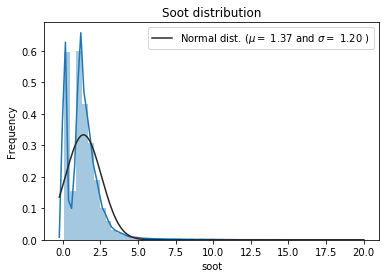

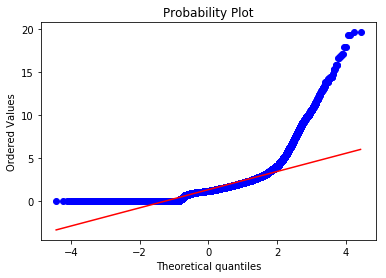

In [5]:
from scipy import stats
from scipy.stats import norm, skew

sns.distplot(data_la['soot'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data_la['soot'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Soot distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data_la['soot'], plot=plt)
plt.show()

/data/anaconda3/envs/base_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until



 mu = 1.32 and sigma = 1.24



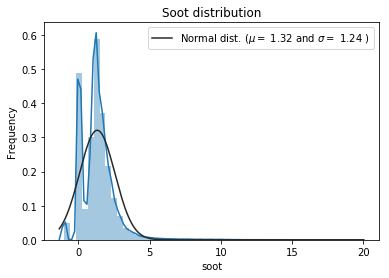

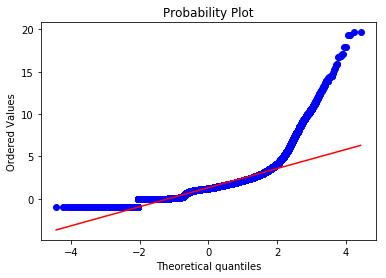

In [6]:
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data_la['soot'] = np.log1p(data_la['soot'])

#Check the new distribution 
sns.distplot(data['soot'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['soot'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Soot distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['soot'], plot=plt)
plt.show()

In [7]:
features =  data_la.columns.values[0:6]   
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
data = data_la
n_train_days = int(len(data)*0.9)
data = data
#前80% 天的数据作为训练数据
train = data[:n_train_days]

#最后20%天的数据作为测试数据
test = data[n_train_days:]


In [8]:
#设定输入输出
train_X, train_y = train[features].values, train['soot'].values
train_y = train_y.reshape(train_y.shape[0],1)

test_X, test_y = test[features].values, test['soot'].values
test_y  = test_y.reshape(test_y.shape[0],1)
print(test_X.shape,test_y.shape)

(14651, 6) (14651, 1)


In [9]:
train_X.shape,train_y.shape

((131852, 6), (131852, 1))

In [30]:
#设计网络结构  #网络设计的不好，不会收敛，每层神经元数，dropout大小,layers数都会有影响
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense,Activation
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization   #加入BN层效果显著，明显收敛
from keras.optimizers import SGD

#在第一个隐层中定义具有50个神经元的LSTM和用于预测close的
#输出层中的1个神经元，输入形状是1个时间步长，具有5个特征。
model = Sequential()
model.add(Dense(10,input_dim = 6))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(5))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('relu'))
model.add(BatchNormalization()) 
#sgd = SGD(lr=0.001, momentum=0.009, decay=0.0, nesterov=False)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='mse', optimizer=adam,metrics=['mae'])

#使用平均绝对误差（MAE）损失函数。该模型将拟合50个批量大小为64的
#训练时期。通过在fit（）函数中设置validation_data参数来跟踪训练
#过程中的训练和测试失败
#epochs和batch_size调了好长时间效果一直不好
history = model.fit(train_X, train_y, nb_epoch=1000, batch_size=1000, validation_data=(test_X, test_y),verbose=2, shuffle=False)
#score = model.evaluate(train_X, train_y,batch_size=360)


Train on 131852 samples, validate on 14651 samples
Epoch 1/1000
 - 1s - loss: 1.4880 - mean_absolute_error: 1.0574 - val_loss: 0.4267 - val_mean_absolute_error: 0.5405
Epoch 2/1000
 - 1s - loss: 1.0634 - mean_absolute_error: 0.8635 - val_loss: 0.5561 - val_mean_absolute_error: 0.6040
Epoch 3/1000
 - 1s - loss: 0.7588 - mean_absolute_error: 0.7169 - val_loss: 0.6202 - val_mean_absolute_error: 0.6686
Epoch 4/1000
 - 1s - loss: 0.5429 - mean_absolute_error: 0.5919 - val_loss: 0.4358 - val_mean_absolute_error: 0.5368
Epoch 5/1000
 - 1s - loss: 0.3982 - mean_absolute_error: 0.5013 - val_loss: 0.3355 - val_mean_absolute_error: 0.4727
Epoch 6/1000
 - 1s - loss: 0.2947 - mean_absolute_error: 0.4331 - val_loss: 0.2915 - val_mean_absolute_error: 0.4603
Epoch 7/1000
 - 1s - loss: 0.2235 - mean_absolute_error: 0.3789 - val_loss: 0.2112 - val_mean_absolute_error: 0.3947
Epoch 8/1000
 - 1s - loss: 0.1847 - mean_absolute_error: 0.3479 - val_loss: 0.1662 - val_mean_absolute_error: 0.3483
Epoch 9/1000


 - 1s - loss: 0.0900 - mean_absolute_error: 0.2092 - val_loss: 0.0786 - val_mean_absolute_error: 0.1913
Epoch 71/1000
 - 1s - loss: 0.0896 - mean_absolute_error: 0.2090 - val_loss: 0.0765 - val_mean_absolute_error: 0.1873
Epoch 72/1000
 - 1s - loss: 0.0891 - mean_absolute_error: 0.2083 - val_loss: 0.0799 - val_mean_absolute_error: 0.1961
Epoch 73/1000
 - 1s - loss: 0.0904 - mean_absolute_error: 0.2101 - val_loss: 0.0764 - val_mean_absolute_error: 0.1875
Epoch 74/1000
 - 1s - loss: 0.0896 - mean_absolute_error: 0.2089 - val_loss: 0.0769 - val_mean_absolute_error: 0.1894
Epoch 75/1000
 - 1s - loss: 0.0897 - mean_absolute_error: 0.2089 - val_loss: 0.0770 - val_mean_absolute_error: 0.1879
Epoch 76/1000
 - 1s - loss: 0.0893 - mean_absolute_error: 0.2080 - val_loss: 0.0773 - val_mean_absolute_error: 0.1875
Epoch 77/1000
 - 1s - loss: 0.0892 - mean_absolute_error: 0.2080 - val_loss: 0.0772 - val_mean_absolute_error: 0.1882
Epoch 78/1000
 - 1s - loss: 0.0891 - mean_absolute_error: 0.2080 - val

Epoch 140/1000
 - 1s - loss: 0.0853 - mean_absolute_error: 0.2026 - val_loss: 0.0782 - val_mean_absolute_error: 0.1938
Epoch 141/1000
 - 1s - loss: 0.0846 - mean_absolute_error: 0.2010 - val_loss: 0.0759 - val_mean_absolute_error: 0.1880
Epoch 142/1000
 - 1s - loss: 0.0859 - mean_absolute_error: 0.2037 - val_loss: 0.0764 - val_mean_absolute_error: 0.1887
Epoch 143/1000
 - 1s - loss: 0.0855 - mean_absolute_error: 0.2033 - val_loss: 0.0761 - val_mean_absolute_error: 0.1881
Epoch 144/1000
 - 1s - loss: 0.0845 - mean_absolute_error: 0.2013 - val_loss: 0.0764 - val_mean_absolute_error: 0.1885
Epoch 145/1000
 - 1s - loss: 0.0847 - mean_absolute_error: 0.2017 - val_loss: 0.0760 - val_mean_absolute_error: 0.1882
Epoch 146/1000
 - 1s - loss: 0.0847 - mean_absolute_error: 0.2014 - val_loss: 0.0777 - val_mean_absolute_error: 0.1905
Epoch 147/1000
 - 1s - loss: 0.0852 - mean_absolute_error: 0.2028 - val_loss: 0.0763 - val_mean_absolute_error: 0.1880
Epoch 148/1000
 - 1s - loss: 0.0845 - mean_absol

Epoch 209/1000
 - 1s - loss: 0.0834 - mean_absolute_error: 0.2001 - val_loss: 0.0762 - val_mean_absolute_error: 0.1874
Epoch 210/1000
 - 1s - loss: 0.0836 - mean_absolute_error: 0.2011 - val_loss: 0.0777 - val_mean_absolute_error: 0.1891
Epoch 211/1000
 - 1s - loss: 0.0826 - mean_absolute_error: 0.1988 - val_loss: 0.0752 - val_mean_absolute_error: 0.1866
Epoch 212/1000
 - 1s - loss: 0.0830 - mean_absolute_error: 0.1993 - val_loss: 0.0753 - val_mean_absolute_error: 0.1877
Epoch 213/1000
 - 1s - loss: 0.0829 - mean_absolute_error: 0.1991 - val_loss: 0.0759 - val_mean_absolute_error: 0.1883
Epoch 214/1000
 - 1s - loss: 0.0839 - mean_absolute_error: 0.2010 - val_loss: 0.0767 - val_mean_absolute_error: 0.1879
Epoch 215/1000
 - 1s - loss: 0.0829 - mean_absolute_error: 0.1993 - val_loss: 0.0751 - val_mean_absolute_error: 0.1877
Epoch 216/1000
 - 1s - loss: 0.0827 - mean_absolute_error: 0.1989 - val_loss: 0.0754 - val_mean_absolute_error: 0.1875
Epoch 217/1000
 - 1s - loss: 0.0830 - mean_absol

Epoch 278/1000
 - 1s - loss: 0.0816 - mean_absolute_error: 0.1969 - val_loss: 0.0795 - val_mean_absolute_error: 0.1955
Epoch 279/1000
 - 1s - loss: 0.0819 - mean_absolute_error: 0.1974 - val_loss: 0.0759 - val_mean_absolute_error: 0.1894
Epoch 280/1000
 - 1s - loss: 0.0819 - mean_absolute_error: 0.1980 - val_loss: 0.0785 - val_mean_absolute_error: 0.1943
Epoch 281/1000
 - 1s - loss: 0.0816 - mean_absolute_error: 0.1971 - val_loss: 0.0766 - val_mean_absolute_error: 0.1913
Epoch 282/1000
 - 1s - loss: 0.0820 - mean_absolute_error: 0.1978 - val_loss: 0.0780 - val_mean_absolute_error: 0.1917
Epoch 283/1000
 - 1s - loss: 0.0816 - mean_absolute_error: 0.1973 - val_loss: 0.0766 - val_mean_absolute_error: 0.1908
Epoch 284/1000
 - 1s - loss: 0.0820 - mean_absolute_error: 0.1980 - val_loss: 0.0781 - val_mean_absolute_error: 0.1938
Epoch 285/1000
 - 1s - loss: 0.0815 - mean_absolute_error: 0.1969 - val_loss: 0.0760 - val_mean_absolute_error: 0.1889
Epoch 286/1000
 - 1s - loss: 0.0828 - mean_absol

Epoch 347/1000
 - 1s - loss: 0.0811 - mean_absolute_error: 0.1967 - val_loss: 0.0799 - val_mean_absolute_error: 0.1994
Epoch 348/1000
 - 1s - loss: 0.0808 - mean_absolute_error: 0.1961 - val_loss: 0.0792 - val_mean_absolute_error: 0.1993
Epoch 349/1000
 - 1s - loss: 0.0808 - mean_absolute_error: 0.1961 - val_loss: 0.0784 - val_mean_absolute_error: 0.1972
Epoch 350/1000
 - 1s - loss: 0.0813 - mean_absolute_error: 0.1967 - val_loss: 0.0799 - val_mean_absolute_error: 0.2003
Epoch 351/1000
 - 1s - loss: 0.0815 - mean_absolute_error: 0.1967 - val_loss: 0.0801 - val_mean_absolute_error: 0.2004
Epoch 352/1000
 - 1s - loss: 0.0822 - mean_absolute_error: 0.1980 - val_loss: 0.1022 - val_mean_absolute_error: 0.2366
Epoch 353/1000
 - 1s - loss: 0.0826 - mean_absolute_error: 0.1993 - val_loss: 0.0848 - val_mean_absolute_error: 0.2041
Epoch 354/1000
 - 1s - loss: 0.0820 - mean_absolute_error: 0.1975 - val_loss: 0.0824 - val_mean_absolute_error: 0.2009
Epoch 355/1000
 - 1s - loss: 0.0812 - mean_absol

Epoch 416/1000
 - 1s - loss: 0.0815 - mean_absolute_error: 0.1965 - val_loss: 0.0832 - val_mean_absolute_error: 0.2051
Epoch 417/1000
 - 1s - loss: 0.0809 - mean_absolute_error: 0.1961 - val_loss: 0.0798 - val_mean_absolute_error: 0.2005
Epoch 418/1000
 - 1s - loss: 0.0807 - mean_absolute_error: 0.1953 - val_loss: 0.0843 - val_mean_absolute_error: 0.2058
Epoch 419/1000
 - 1s - loss: 0.0808 - mean_absolute_error: 0.1954 - val_loss: 0.0821 - val_mean_absolute_error: 0.2020
Epoch 420/1000
 - 1s - loss: 0.0814 - mean_absolute_error: 0.1968 - val_loss: 0.0849 - val_mean_absolute_error: 0.2052
Epoch 421/1000
 - 1s - loss: 0.0808 - mean_absolute_error: 0.1960 - val_loss: 0.0804 - val_mean_absolute_error: 0.2017
Epoch 422/1000
 - 1s - loss: 0.0807 - mean_absolute_error: 0.1955 - val_loss: 0.0803 - val_mean_absolute_error: 0.1996
Epoch 423/1000
 - 1s - loss: 0.0811 - mean_absolute_error: 0.1967 - val_loss: 0.0831 - val_mean_absolute_error: 0.2058
Epoch 424/1000
 - 1s - loss: 0.0810 - mean_absol

Epoch 485/1000
 - 1s - loss: 0.0812 - mean_absolute_error: 0.1966 - val_loss: 0.0806 - val_mean_absolute_error: 0.2023
Epoch 486/1000
 - 1s - loss: 0.0806 - mean_absolute_error: 0.1954 - val_loss: 0.0792 - val_mean_absolute_error: 0.2021
Epoch 487/1000
 - 1s - loss: 0.0814 - mean_absolute_error: 0.1968 - val_loss: 0.0794 - val_mean_absolute_error: 0.2010
Epoch 488/1000
 - 1s - loss: 0.0809 - mean_absolute_error: 0.1963 - val_loss: 0.0823 - val_mean_absolute_error: 0.2053
Epoch 489/1000
 - 1s - loss: 0.0808 - mean_absolute_error: 0.1959 - val_loss: 0.0792 - val_mean_absolute_error: 0.1993
Epoch 490/1000
 - 1s - loss: 0.0805 - mean_absolute_error: 0.1952 - val_loss: 0.0807 - val_mean_absolute_error: 0.2030
Epoch 491/1000
 - 1s - loss: 0.0806 - mean_absolute_error: 0.1955 - val_loss: 0.0797 - val_mean_absolute_error: 0.2012
Epoch 492/1000
 - 1s - loss: 0.0808 - mean_absolute_error: 0.1960 - val_loss: 0.0810 - val_mean_absolute_error: 0.2018
Epoch 493/1000
 - 1s - loss: 0.0804 - mean_absol

Epoch 554/1000
 - 1s - loss: 0.0800 - mean_absolute_error: 0.1946 - val_loss: 0.0792 - val_mean_absolute_error: 0.1986
Epoch 555/1000
 - 1s - loss: 0.0800 - mean_absolute_error: 0.1946 - val_loss: 0.0815 - val_mean_absolute_error: 0.2017
Epoch 556/1000
 - 1s - loss: 0.0805 - mean_absolute_error: 0.1949 - val_loss: 0.0809 - val_mean_absolute_error: 0.2000
Epoch 557/1000
 - 1s - loss: 0.0804 - mean_absolute_error: 0.1951 - val_loss: 0.0807 - val_mean_absolute_error: 0.2013
Epoch 558/1000
 - 1s - loss: 0.0808 - mean_absolute_error: 0.1956 - val_loss: 0.0802 - val_mean_absolute_error: 0.1990
Epoch 559/1000
 - 1s - loss: 0.0810 - mean_absolute_error: 0.1962 - val_loss: 0.0805 - val_mean_absolute_error: 0.2013
Epoch 560/1000
 - 1s - loss: 0.0809 - mean_absolute_error: 0.1957 - val_loss: 0.0796 - val_mean_absolute_error: 0.2013
Epoch 561/1000
 - 1s - loss: 0.0803 - mean_absolute_error: 0.1949 - val_loss: 0.0828 - val_mean_absolute_error: 0.2067
Epoch 562/1000
 - 1s - loss: 0.0809 - mean_absol

Epoch 623/1000
 - 1s - loss: 0.0808 - mean_absolute_error: 0.1955 - val_loss: 0.0801 - val_mean_absolute_error: 0.2009
Epoch 624/1000
 - 1s - loss: 0.0802 - mean_absolute_error: 0.1947 - val_loss: 0.0797 - val_mean_absolute_error: 0.2003
Epoch 625/1000
 - 1s - loss: 0.0808 - mean_absolute_error: 0.1954 - val_loss: 0.0815 - val_mean_absolute_error: 0.2035
Epoch 626/1000
 - 1s - loss: 0.0805 - mean_absolute_error: 0.1952 - val_loss: 0.0827 - val_mean_absolute_error: 0.2068
Epoch 627/1000
 - 1s - loss: 0.0805 - mean_absolute_error: 0.1956 - val_loss: 0.0812 - val_mean_absolute_error: 0.2035
Epoch 628/1000
 - 1s - loss: 0.0810 - mean_absolute_error: 0.1960 - val_loss: 0.0827 - val_mean_absolute_error: 0.2058
Epoch 629/1000
 - 1s - loss: 0.0801 - mean_absolute_error: 0.1944 - val_loss: 0.0805 - val_mean_absolute_error: 0.2030
Epoch 630/1000
 - 1s - loss: 0.0804 - mean_absolute_error: 0.1950 - val_loss: 0.0797 - val_mean_absolute_error: 0.2003
Epoch 631/1000
 - 1s - loss: 0.0806 - mean_absol

Epoch 692/1000
 - 1s - loss: 0.0803 - mean_absolute_error: 0.1949 - val_loss: 0.0815 - val_mean_absolute_error: 0.2038
Epoch 693/1000
 - 1s - loss: 0.0808 - mean_absolute_error: 0.1956 - val_loss: 0.0807 - val_mean_absolute_error: 0.2009
Epoch 694/1000
 - 1s - loss: 0.0820 - mean_absolute_error: 0.1981 - val_loss: 0.0853 - val_mean_absolute_error: 0.2068
Epoch 695/1000
 - 1s - loss: 0.0806 - mean_absolute_error: 0.1951 - val_loss: 0.0861 - val_mean_absolute_error: 0.2073
Epoch 696/1000
 - 1s - loss: 0.0809 - mean_absolute_error: 0.1957 - val_loss: 0.0836 - val_mean_absolute_error: 0.2028
Epoch 697/1000
 - 1s - loss: 0.0810 - mean_absolute_error: 0.1960 - val_loss: 0.0839 - val_mean_absolute_error: 0.2036
Epoch 698/1000
 - 1s - loss: 0.0806 - mean_absolute_error: 0.1953 - val_loss: 0.0817 - val_mean_absolute_error: 0.2007
Epoch 699/1000
 - 1s - loss: 0.0803 - mean_absolute_error: 0.1946 - val_loss: 0.0833 - val_mean_absolute_error: 0.2058
Epoch 700/1000
 - 1s - loss: 0.0799 - mean_absol

Epoch 761/1000
 - 1s - loss: 0.0804 - mean_absolute_error: 0.1947 - val_loss: 0.0863 - val_mean_absolute_error: 0.2065
Epoch 762/1000
 - 1s - loss: 0.0805 - mean_absolute_error: 0.1954 - val_loss: 0.0826 - val_mean_absolute_error: 0.2042
Epoch 763/1000
 - 1s - loss: 0.0806 - mean_absolute_error: 0.1953 - val_loss: 0.0803 - val_mean_absolute_error: 0.2012
Epoch 764/1000
 - 1s - loss: 0.0806 - mean_absolute_error: 0.1953 - val_loss: 0.0807 - val_mean_absolute_error: 0.2024
Epoch 765/1000
 - 1s - loss: 0.0809 - mean_absolute_error: 0.1957 - val_loss: 0.0796 - val_mean_absolute_error: 0.2006
Epoch 766/1000
 - 1s - loss: 0.0808 - mean_absolute_error: 0.1956 - val_loss: 0.0797 - val_mean_absolute_error: 0.2019
Epoch 767/1000
 - 1s - loss: 0.0805 - mean_absolute_error: 0.1946 - val_loss: 0.0818 - val_mean_absolute_error: 0.2047
Epoch 768/1000
 - 1s - loss: 0.0817 - mean_absolute_error: 0.1969 - val_loss: 0.0804 - val_mean_absolute_error: 0.2014
Epoch 769/1000
 - 1s - loss: 0.0800 - mean_absol

Epoch 830/1000
 - 1s - loss: 0.0806 - mean_absolute_error: 0.1952 - val_loss: 0.0822 - val_mean_absolute_error: 0.2043
Epoch 831/1000
 - 1s - loss: 0.0797 - mean_absolute_error: 0.1937 - val_loss: 0.0826 - val_mean_absolute_error: 0.2044
Epoch 832/1000
 - 1s - loss: 0.0803 - mean_absolute_error: 0.1943 - val_loss: 0.0813 - val_mean_absolute_error: 0.2025
Epoch 833/1000
 - 1s - loss: 0.0804 - mean_absolute_error: 0.1950 - val_loss: 0.0803 - val_mean_absolute_error: 0.1999
Epoch 834/1000
 - 1s - loss: 0.0803 - mean_absolute_error: 0.1942 - val_loss: 0.0805 - val_mean_absolute_error: 0.2017
Epoch 835/1000
 - 1s - loss: 0.0805 - mean_absolute_error: 0.1951 - val_loss: 0.0800 - val_mean_absolute_error: 0.1999
Epoch 836/1000
 - 1s - loss: 0.0796 - mean_absolute_error: 0.1936 - val_loss: 0.0811 - val_mean_absolute_error: 0.2036
Epoch 837/1000
 - 1s - loss: 0.0807 - mean_absolute_error: 0.1954 - val_loss: 0.0801 - val_mean_absolute_error: 0.2001
Epoch 838/1000
 - 1s - loss: 0.0801 - mean_absol

Epoch 899/1000
 - 1s - loss: 0.0808 - mean_absolute_error: 0.1955 - val_loss: 0.0836 - val_mean_absolute_error: 0.2044
Epoch 900/1000
 - 1s - loss: 0.0803 - mean_absolute_error: 0.1950 - val_loss: 0.0803 - val_mean_absolute_error: 0.2018
Epoch 901/1000
 - 1s - loss: 0.0802 - mean_absolute_error: 0.1944 - val_loss: 0.0798 - val_mean_absolute_error: 0.2001
Epoch 902/1000
 - 1s - loss: 0.0806 - mean_absolute_error: 0.1954 - val_loss: 0.0813 - val_mean_absolute_error: 0.2040
Epoch 903/1000
 - 1s - loss: 0.0804 - mean_absolute_error: 0.1945 - val_loss: 0.0811 - val_mean_absolute_error: 0.2024
Epoch 904/1000
 - 1s - loss: 0.0802 - mean_absolute_error: 0.1947 - val_loss: 0.0804 - val_mean_absolute_error: 0.2010
Epoch 905/1000
 - 1s - loss: 0.0803 - mean_absolute_error: 0.1945 - val_loss: 0.0798 - val_mean_absolute_error: 0.1999
Epoch 906/1000
 - 1s - loss: 0.0804 - mean_absolute_error: 0.1950 - val_loss: 0.0819 - val_mean_absolute_error: 0.2038
Epoch 907/1000
 - 1s - loss: 0.0800 - mean_absol

Epoch 968/1000
 - 1s - loss: 0.0802 - mean_absolute_error: 0.1946 - val_loss: 0.0880 - val_mean_absolute_error: 0.2087
Epoch 969/1000
 - 1s - loss: 0.0804 - mean_absolute_error: 0.1948 - val_loss: 0.0837 - val_mean_absolute_error: 0.2034
Epoch 970/1000
 - 1s - loss: 0.0808 - mean_absolute_error: 0.1956 - val_loss: 0.0863 - val_mean_absolute_error: 0.2088
Epoch 971/1000
 - 1s - loss: 0.0799 - mean_absolute_error: 0.1941 - val_loss: 0.0844 - val_mean_absolute_error: 0.2044
Epoch 972/1000
 - 1s - loss: 0.0806 - mean_absolute_error: 0.1952 - val_loss: 0.0822 - val_mean_absolute_error: 0.2029
Epoch 973/1000
 - 1s - loss: 0.0804 - mean_absolute_error: 0.1943 - val_loss: 0.0811 - val_mean_absolute_error: 0.2036
Epoch 974/1000
 - 1s - loss: 0.0801 - mean_absolute_error: 0.1938 - val_loss: 0.0799 - val_mean_absolute_error: 0.2009
Epoch 975/1000
 - 1s - loss: 0.0799 - mean_absolute_error: 0.1941 - val_loss: 0.0804 - val_mean_absolute_error: 0.2015
Epoch 976/1000
 - 1s - loss: 0.0802 - mean_absol

In [31]:
model.save('model_dnn_drop.h5') 

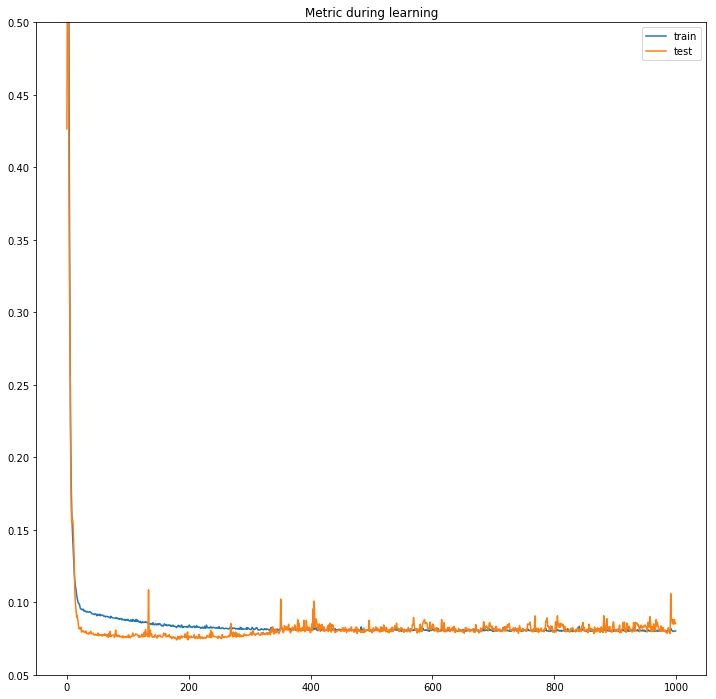

In [32]:
fig,ax = plt.subplots(figsize = (12,12))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.set_ylim(0.05, 0.5)
plt.title('Metric during learning')
plt.legend()
plt.show()


In [19]:
def figures(history,figure_name="plots"):
    """ method to visualize accuracies and loss vs epoch for training as well as testind data\n
        Argumets: history     = an instance returned by model.fit method\n
                  figure_name = a string representing file name to plots. By default it is set to "plots" \n
       Usage: hist = model.fit(X,y)\n              figures(hist) """
    from keras.callbacks import History
    if isinstance(history,History):
        import matplotlib.pyplot as plt
        hist     = history.history 
        epoch    = history.epoch
        acc      = hist['acc']
        loss     = hist['loss']
        val_loss = hist['val_loss']
        val_acc  = hist['val_acc']
        plt.figure(1)
 
        plt.subplot(221)
        plt.plot(epoch,acc)
        plt.title("Training accuracy vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")     
 
        plt.subplot(222)
        plt.plot(epoch,loss)
        plt.title("Training loss vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")  
 
        plt.subplot(223)
        plt.plot(epoch,val_acc)
        plt.title("Validation Acc vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Validation Accuracy")  
 
        plt.subplot(224)
        plt.plot(epoch,val_loss)
        plt.title("Validation loss vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Validation Loss")  
        plt.tight_layout()
        plt.savefig(figure_name)
    else:
        print("Input Argument is not an instance of class History")

figures(history)

KeyError: 'acc'

In [33]:
#计算预测值和实际值之间的均方根误差
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
test = pd.read_csv('test.csv')
test = test.values
#test = test.reshape((test.shape[0], 1, test.shape[1]))
predictions = model.predict(test)
rnn_pred = np.expm1(predictions)

In [34]:
rnn_pred = rnn_pred.reshape(3661)

In [35]:
sub = pd.DataFrame()
sub['soot'] = rnn_pred
sub.to_csv('submission_mse_dnn_dropout.csv',index=False)